# Assignment for Applied Machine Learning 
## Exploring the FEC 2016 Elections Data
>Stergios Sozos 8170129
>
>Department of Management Science and Technology
>
>Athens University of Economics and Business
>
>stergiossozos@outlook.com

***


Before we start, we need to download some files. These files must be moved to the same file where our notebook is saved. Some files are read through the url, because they are smaller and not much time is needed, but the big ones need to be downloaded in advance, and no url is used, just their location and filename. 
Here is the full list of the files we need:
* [itpas2.txt](https://www.fec.gov/files/bulk-downloads/2016/pas216.zip)
* [cn.txt](https://www.fec.gov/files/bulk-downloads/2016/cn16.zip)
* [webk16.txt](https://www.fec.gov/files/bulk-downloads/2016/webk16.zip)
* [itcont.txt](https://www.fec.gov/files/bulk-downloads/2016/indiv16.zip)
* [cm.txt](https://www.fec.gov/files/bulk-downloads/2016/cm16.zip)
* [oppexp.txt](https://www.fec.gov/files/bulk-downloads/2016/oppexp16.zip)
* [itoth](https://www.fec.gov/files/bulk-downloads/2016/oth16.zip)

Most of the files were found on the [fec site](https://www.fec.gov/data/browse-data/?tab=bulk-data) 

For the first question :
> "Identify the top 5 Political Action Committees (PACs), or rather, super-PACs, that supported each of the two presidential candidates, giving the amount of money raised and spent by each one of them."




Before we start, we will import some libraries that we will need later, and set some options for pandas that we will need for displaying the data.

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

import matplotlib

from collections import defaultdict

%matplotlib inline

matplotlib.style.use('ggplot')

pd.set_option("display.max_columns", None)
pd.set_option('float_format', '{:f}'.format)

In C:\Users\Sterg\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Sterg\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Sterg\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Sterg\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases lat

Now we will read a file, which we will use to find which commitees support  the 2 candidates and which are opposed to them. 

How? The file we will read contains a column which shows the id of commitees (CMTE_ID) and transactions it made (TRANSACTION_AMT), but also shows to whom are these transactions addressed (CAND_ID) 

ATTENTION! The key here is the  column (TRANSACTION_TP) which shows if the transaction was for or against the candidate. 

We will first need to read the headers 

In [2]:
#read headers and convert them to list
headers_df = pd.read_csv('https://www.fec.gov/files/bulk-downloads/data_dictionaries/pas2_header_file.csv')
headers = headers_df.columns.tolist()

Now we can read the file we mentioned above and connect it to the headers. Then, we will keep only the columns that we are interested in (the ones we mentioned above)

We will also print the first 5 rows so we can have a visual of what we are doing

In [3]:
#read file itpas2
data_types = { header: np.str for header in headers }
data_types['TRANSACTION_AMT'] = np.float
data_types
cmpas = pd.read_csv('itpas2.txt', 
                  sep="|", 
                  index_col=False, 
                  names=headers,
                  dtype=data_types)
#keep the columns we need
cmpasimp= cmpas[['CMTE_ID','NAME','TRANSACTION_AMT','CAND_ID','TRANSACTION_TP']]
#Visualise the first 5 rows
cmpasimp.head(5)

,CMTE_ID,NAME,TRANSACTION_AMT,CAND_ID,TRANSACTION_TP
0,C00548198,BLAINE FOR CONGRESS,2500.000000,H8MO09153,24K
1,C00548198,KEVIN MCCARTHY FOR CONGRESS,1000.000000,H6CA22125,24K
2,C00235739,DAN NEWHOUSE FOR CONGRESS,2500.000000,H4WA04104,24K
3,C00235739,CATHY MCMORRIS RODGERS FOR CONGRESS,1000.000000,H4WA05077,24K
4,C00235739,MANCHIN FOR WEST VIRGINIA,1000.000000,S0WV00090,24K


Now we have to link the candidate's id to the candidate's name so we can recognise and search the ones we are interested in.

Just like before, we first read the headers

In [4]:
cn_headers_df = pd.read_csv(
    'https://www.fec.gov/data/browse-data/files/bulk-downloads/data_dictionaries/cn_header_file.csv')

cn_headers = cn_headers_df.columns.tolist()

So we can now read the file and connect it to the headers

In [5]:
cn = pd.read_csv('cn.txt', 
                  sep="|", 
                  index_col=False, 
                  names=cn_headers)

Note: Only the first 2 columns (CAND_ID	and CAND_NAME) are of interest to us, but before that we also need some columns to filter the candidates
These columns are
>CAND_ELECTION_YR contains the election year of the candidate(we need 2016)
>
>CAND_OFFICE contains the type of office house,president or senate (we need P=President)
>
>CAND_STATUS is the candidate status(we need C=Statutory candidate)
>

We can now filter the candidates, and then print the first 5 so we can have a visual on what we are doing

In [6]:
cn = cn.loc[(cn['CAND_ELECTION_YR'] == 2016) & (cn['CAND_OFFICE'] == 'P') & (cn['CAND_STATUS'] == 'C')]
cn.head(5)

,CAND_ID,CAND_NAME,CAND_PTY_AFFILIATION,CAND_ELECTION_YR,CAND_OFFICE_ST,CAND_OFFICE,CAND_OFFICE_DISTRICT,CAND_ICI,CAND_STATUS,CAND_PCC,CAND_ST1,CAND_ST2,CAND_CITY,CAND_ST,CAND_ZIP
4367,P00003392,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE",DEM,2016,US,P,0.000000,O,C,C00575795,NaN,NaN,NEW YORK,NY,nan
4377,P00003962,"SCHRINER, JOSEPH CHARLES",UNK,2016,US,P,0.000000,O,C,C00385153,542 S MAIN ST,NaN,BLUFFTON,OH,45817.000000
4379,P00004275,"BROWN, HARLEY D",NNE,2016,US,P,0.000000,O,C,C00569442,6086 HAPPY LANE,NaN,NAMPA,ID,83686.000000
4385,P00004861,"BICKELMEYER, MICHAEL",REP,2016,US,P,0.000000,O,C,C00553206,399 PEARL ROAD,NaN,BRUNSWICK,OH,44212.000000
4478,P20002671,"JOHNSON, GARY / WILLIAM ""BILL"" WELD",LIB,2016,US,P,0.000000,O,C,C00605568,NaN,NaN,SALT LAKE CITY,UT,nan


Don't worry, we won't keep the rest of the columns for more. 

On the next step, which is the merge of the transaction file with the candidate file, we will keep only the columns we need (which is just the name)

As for the merge, we use the candidate id as the key , and perform an inner merge. The result will be the transactions file, but now we also have the candidate's names -not just the id. Again we visualise by first 5 rows

In [7]:
cmpasimp = pd.merge(cmpasimp, 
               cn[['CAND_ID', 'CAND_NAME']], 
               on='CAND_ID',
               how='inner')
#Visualise the first 5 rows
cmpasimp.head(5)

,CMTE_ID,NAME,TRANSACTION_AMT,CAND_ID,TRANSACTION_TP,CAND_NAME
0,C00553966,HILLARY FOR AMERICA,2700.000000,P00003392,24K,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE"
1,C00574228,HILLLARY FOR AMERICA,500.000000,P00003392,24K,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE"
2,C00574228,HILLLARY FOR AMERICA,2200.000000,P00003392,24K,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE"
3,C00540955,HILLARY FOR AMERICA,5000.000000,P00003392,24K,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE"
4,C00342048,HILLARY FOR AMERICA,5000.000000,P00003392,24K,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE"


Let's go back to our question. It asks for the 2 main candidates. Hillary and Trump. Let's keep only these two. 

In [8]:
cmpasimp = cmpasimp[cmpasimp['CAND_NAME'].isin(['CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE', 'TRUMP, DONALD J. / MICHAEL R. PENCE '])]

### Hillary Supporters

It't now time to find out which from these commitees are "with" hillary, meaning that they either support Hillary herself, or they are opposed to Trump. But how are we going to find this information?

First, we create 2 filters,

One that contains all the transactions with type 24E (meaning they support the candidate) combined with Hillary's name, and

One that contains all the transactions with type 24A (meaning they are opposed to the candidate) combined with Trumps's name

Then we combine these 2, we group them by commitee, showing also the candidate id and transaction type, and the grouping is based on sum of the transaction amount.

In [9]:
#Filter 1, Hillary support
HillarySupport= cmpasimp[cmpasimp['TRANSACTION_TP'].isin(['24E']) & cmpasimp['CAND_NAME'].isin(['CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE']) ]

#Filter 2, anti-Trump
TrumpOppose = cmpasimp[cmpasimp['TRANSACTION_TP'].isin(['24A']) & cmpasimp['CAND_NAME'].isin(['TRUMP, DONALD J. / MICHAEL R. PENCE '])]

#Combine these 2
FinalHillaryseries = [HillarySupport,TrumpOppose]
FinalHillary = pd.concat(FinalHillaryseries)

#Group, summing the transactions.
FinalHillary = FinalHillary\
                       .groupby(['CMTE_ID'])['TRANSACTION_AMT'].sum()\
   .sort_values(ascending=False).to_frame('amount').reset_index()
#Visualise top 10 rows
FinalHillary.head(10)

,CMTE_ID,amount
0,C00495861,132535920.000000
1,C00603621,16353117.000000
2,C00523621,13499952.000000
3,C00615815,13240861.000000
4,C00473918,11627748.000000
5,C00625525,9922027.000000
6,C00486845,8432699.000000
7,C00620971,7540260.000000
8,C00547349,7096072.000000
9,C00487470,7054203.000000


### Trump Supporters

It't now time to find out which of these commitees are "with" Trump.

In [10]:
#Filter 1, Trump support
TrumpSupport= cmpasimp[cmpasimp['TRANSACTION_TP'].isin(['24E']) & cmpasimp['CAND_NAME'].isin(['TRUMP, DONALD J. / MICHAEL R. PENCE ']) ]

#Filter 2, anti-Hillary
HillaryOppose = cmpasimp[cmpasimp['TRANSACTION_TP'].isin(['24A']) & cmpasimp['CAND_NAME'].isin(['CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE'])]

#Combine these 2
FinalTrumpseries = [TrumpSupport,HillaryOppose]
FinalTrump = pd.concat(FinalTrumpseries)

#Group, summing the transactions.
FinalTrump = FinalTrump\
                       .groupby(['CMTE_ID'])['TRANSACTION_AMT'].sum()\
   .sort_values(ascending=False).to_frame('amount').reset_index()

#Visualise top 10
FinalTrump.head(10)

,CMTE_ID,amount
0,C00574533,24219101.000000
1,C00608489,23885544.000000
2,C00618876,21197098.000000
3,C90013301,21086632.000000
4,C00053553,9315549.000000
5,C00490730,5728857.000000
6,C00575373,4376616.000000
7,C00581934,4058735.000000
8,C00544767,3647257.000000
9,C00566174,3602443.000000


Now that we know which commitee supports each candidate we will jump to a different file, which will show if the commitee is a super pac, but also the total amount spend and raised by each.

Here we get the headers file, so we can use it in the next step, where we get the whole file

In [11]:
# Code for getting the last table from a site
url = 'https://www.fec.gov/campaign-finance-data/pac-and-party-summary-file-description/'
html = requests.get(url).content
df_list = pd.read_html(html)
df = df_list[-1]
# Keeping only the column containng the headers
HeadersPacSum = df.loc[1:,0]


Having read the headers, now we can use it for the file from "Pac Summary". We don't need all of the columns but we are going to remove them later.

In [12]:
PacSum = pd.read_csv('webk16.txt', 
                  sep="|", 
                  index_col=False, 
                  names=HeadersPacSum)
#Visualise the first 5 rows
PacSum.head(5)

,CMTE_ID,CMTE_NM,CMTE_TP,CMTE_DSGN,CMTE_FILING_FREQ,TTL_RECEIPTS,TRANS_FROM_AFF,INDV_CONTRIB,OTHER_POL_CMTE_CONTRIB,CAND_CONTRIB,CAND_LOANS,TTL_LOANS_RECEIVED,TTL_DISB,TRANF_TO_AFF,INDV_REFUNDS,OTHER_POL_CMTE_REFUNDS,CAND_LOAN_REPAY,LOAN_REPAY,COH_BOP,COH_COP,DEBTS_OWED_BY,NONFED_TRANS_RECEIVED,CONTRIB_TO_OTHER_CMTE,IND_EXP,PTY_COORD_EXP,NONFED_SHARE_EXP,CVG_END_DT
0,C00000059,HALLMARK CARDS PAC,Q,U,M,123198.920000,0.000000,123198.920000,0.000000,0.000000,0.000000,0.000000,88500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,104794.360000,139493.280000,0.000000,0.000000,88500.000000,0.000000,0.000000,0.000000,12/31/2016
1,C00000422,AMERICAN MEDICAL ASSOCIATION POLITICAL ACTION ...,Q,B,M,2114478.160000,0.000000,2099958.160000,0.000000,0.000000,0.000000,0.000000,2047839.790000,1790.000000,12621.710000,0.000000,0.000000,0.000000,552464.380000,619102.750000,0.000000,0.000000,1853000.000000,141616.350000,0.000000,0.000000,12/31/2016
2,C00000489,D R I V E POLITICAL FUND CHAPTER 886,N,U,Q,41455.170000,41453.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39672.850000,0.000000,0.000000,0.000000,0.000000,0.000000,192.000000,1974.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12/31/2016
3,C00000547,KANSAS MEDICAL SOCIETY POLITICAL ACTION COMMITTEE,Q,U,Q,19065.000000,0.000000,19065.000000,0.000000,0.000000,0.000000,0.000000,17592.500000,2592.500000,0.000000,0.000000,0.000000,0.000000,4681.260000,6153.760000,0.000000,0.000000,15000.000000,0.000000,0.000000,0.000000,12/31/2016
4,C00000638,INDIANA STATE MEDICAL ASSOCIATION POLITICAL AC...,Q,U,Q,143170.000000,0.000000,142570.000000,0.000000,0.000000,0.000000,0.000000,85918.480000,13222.500000,0.000000,0.000000,0.000000,0.000000,35530.910000,92782.430000,0.000000,0.000000,3000.000000,0.000000,0.000000,0.000000,12/31/2016


We now filter the commitees keeping only the ones that are super pac (it's the letter O from the column commitee type)

In [13]:
PacSum = PacSum[PacSum['CMTE_TP'].isin(['O'])]

We then sort by the expenditure (as this is asked on the question) and keep only the columns we need.

In [14]:
PacSumsorted = PacSum.sort_values(by=['IND_EXP'], ascending=False)
PacSumsorted = PacSumsorted[['CMTE_ID','CMTE_NM','IND_EXP','TTL_RECEIPTS']]
PacSumsorted.head(10)

,CMTE_ID,CMTE_NM,IND_EXP,TTL_RECEIPTS
10963,C00495861,PRIORITIES USA ACTION,133408056.410000,192065767.580000
5170,C00571372,RIGHT TO RISE USA,86817478.310000,121695224.050000
5194,C00571703,SENATE LEADERSHIP FUND,85994327.660000,116911967.510000
3161,C00484642,SENATE MAJORITY PAC,75413534.870000,92821080.670000
3970,C00541292,CONSERVATIVE SOLUTIONS PAC,55443629.890000,60564219.160000
10879,C00495028,HOUSE MAJORITY PAC,47470427.480000,55872071.230000
11415,C00504530,CONGRESSIONAL LEADERSHIP FUND,40125756.020000,51053019.840000
3098,C00473918,WOMEN VOTE!,33167398.370000,36685866.330000
4739,C00564765,"FREEDOM PARTNERS ACTION FUND, INC.",29728850.260000,28201407.050000
5664,C00580381,GRANITE STATE SOLUTIONS,24267139.700000,24470200.000000


Now, we will combine the 2 dataframes to find our final top 5 for each candidate


### Hillary Top 5 Super-Pacs
We will merge the Hillary dataframe (which contains the hillary supporters) with the super pac dataframe based on the commitee id. Then we will remove duplicates (which are caused by commitees who both support hillary and are opposed to trump) and print thhe top 5 commitees for Hillary

The column IND_EXP shows the total amount spent
The column TTL_RECEIPTS shows the total amount raised



In [15]:
Hillary = pd.merge(PacSumsorted,FinalHillary,
                on='CMTE_ID',
                how='inner')
Hillary = Hillary.drop_duplicates('CMTE_ID')
#Visualise the top 5 rows
Hillary.head(5)

,CMTE_ID,CMTE_NM,IND_EXP,TTL_RECEIPTS,amount
0,C00495861,PRIORITIES USA ACTION,133408056.410000,192065767.580000,132535920.000000
1,C00571372,RIGHT TO RISE USA,86817478.310000,121695224.050000,25162.000000
2,C00484642,SENATE MAJORITY PAC,75413534.870000,92821080.670000,2051868.000000
3,C00541292,CONSERVATIVE SOLUTIONS PAC,55443629.890000,60564219.160000,4774412.000000
4,C00495028,HOUSE MAJORITY PAC,47470427.480000,55872071.230000,2761357.000000


### Trump Top 5 Super-Pacs
We will merge the Trump dataframe (which contains the Trump supporters) with the super pac dataframe based on the commitee id. Then we will remove duplicates (which are caused by commitees who both support Trump and are opposed to Hillary) and print the top 5 commitees for Trump

The column IND_EXP shows the total amount spent
The column TTL_RECEIPTS shows the total amount raised



In [16]:
Trump = pd.merge(PacSumsorted,FinalTrump,
                on='CMTE_ID',
                how='inner')
Trump = Trump.drop_duplicates('CMTE_ID')
#Visualise the top 5 rows
Trump.head(5)

,CMTE_ID,CMTE_NM,IND_EXP,TTL_RECEIPTS,amount
0,C00564765,"FREEDOM PARTNERS ACTION FUND, INC.",29728850.260000,28201407.050000,36329.000000
1,C00574533,FUTURE45,24264041.870000,24996520.040000,24219101.000000
2,C00618876,REBUILDING AMERICA NOW,19817596.850000,23616516.940000,21197098.000000
3,C00487470,CLUB FOR GROWTH ACTION,19182422.190000,19936801.970000,541.000000
4,C00523621,UNITED WE CAN,13734221.790000,24206986.360000,4392.000000


# Important
Are all those commitees Hillary and Trump supporters correspondigly?
Probably not 100%
To create the lists above we accepted that if a commitee has given even a small amount to a candidate, it's supporting him, or it's opposed to him. We focus only on those 2 candidates, so for us each commitee is either supportin Trump or Hillary (or noone if it hasn't given anything to the 2 mentioned).
A different apporach would be to first sort based on the transaction amounts (let's say to keep the top 10) and then merge it to the pac summary dataframe, so we will not have small amounts included.
This approach is shown below for each candidate

#### Hillary top 5

In [17]:
Hillary = pd.merge(PacSumsorted,FinalHillary.head(10),
                on='CMTE_ID',
                how='inner')
Hillary = Hillary.drop_duplicates('CMTE_ID')
Hillary.head(5)

,CMTE_ID,CMTE_NM,IND_EXP,TTL_RECEIPTS,amount
0,C00495861,PRIORITIES USA ACTION,133408056.410000,192065767.580000,132535920.000000
1,C00473918,WOMEN VOTE!,33167398.370000,36685866.330000,11627748.000000
2,C00487470,CLUB FOR GROWTH ACTION,19182422.190000,19936801.970000,7054203.000000
3,C00603621,OUR PRINCIPLES PAC,18327118.770000,19024903.050000,16353117.000000
4,C00486845,LCV VICTORY FUND,15703967.090000,19649152.670000,8432699.000000


#### Trump top 5

In [18]:
Trump = pd.merge(PacSumsorted,FinalTrump.head(10),
                on='CMTE_ID',
                how='inner')
Trump = Trump.drop_duplicates('CMTE_ID')
Trump.head(5)

,CMTE_ID,CMTE_NM,IND_EXP,TTL_RECEIPTS,amount
0,C00574533,FUTURE45,24264041.870000,24996520.040000,24219101.000000
1,C00618876,REBUILDING AMERICA NOW,19817596.850000,23616516.940000,21197098.000000
2,C00575373,MAKE AMERICA NUMBER 1,13432442.890000,20737584.810000,4376616.000000
3,C00581934,REFORM AMERICA FUND,7270211.790000,9028596.470000,4058735.000000
4,C00490730,RGA RIGHT DIRECTION PAC,5426475.670000,22781720.740000,5728857.000000


#### Note: We could also filter the commitees by setting a minimum amount for each. For example if a commitee has spent 5.000 dollars to Clinton, we suppose that it is a Hillary supporter. But what if this was 100? Or 100.000 ? We didn't set a minimum so we may have a included some supporters that are not focused 100% on the candidate , but they are still supporters

For the second question: 

> Identify the top 10 individual donors (i.e., persons) for each of the two presidential candidates and the amount they spent. In order to do that, you should know that donations are not always to a fundraising committee that can be directly linked to a candidate, but they can be due to other entities such as PACs.

We will split this question in 2 parts
The first part will be about finding the individual donors to committees who are directly linked to a candidate, and the second about individual donors who are indirectly linked to a candidate.


Before starting, let's import our main dataframe which contains all the individual transactions to commitees.
As always, we start with the headers

In [19]:
headers_df = pd.read_csv('https://www.fec.gov/files/bulk-downloads/data_dictionaries/indiv_header_file.csv')
headers = headers_df.columns.tolist()
data_types = { header: np.str for header in headers }
data_types['TRANSACTION_AMT'] = np.float

Moving on to the dataframe, we will skip some solumns before even reading it, as they are not useful for our question.
The ones that are of interest to us are in the "usecols" parameter
We also keep only rows where entity tp is ind, which means that the transaction was performed by an individual(IND = Individual (a person), as the question asks for. We consider candidates as "Candidates" type and we dont include them in the individual donors.

In [20]:
fec = pd.read_csv('itcont.txt', 
                  sep="|", 
                  index_col=False, 
                  names=headers,
                  usecols = lambda column : column in 
["CMTE_ID","NAME","ENTITY_TP","TRANSACTION_AMT","TRANSACTION_DT"],
                  dtype=data_types)
# Keep only individuals
fec = fec[fec['ENTITY_TP'].isin(['IND'])]
#Set date type to transaction date
fec['TRANSACTION_DT'] = pd.to_datetime(fec['TRANSACTION_DT'], format='%m%d%Y', errors='coerce')
#Visualise the first 10 rows
fec.sample(10)

,CMTE_ID,ENTITY_TP,NAME,TRANSACTION_DT,TRANSACTION_AMT
14236907,C00429175,IND,"AMOROS, ABRAHAM",2016-04-15,75.000000
18660840,C00401224,IND,"GINSBURG, MIRYAM SOMAN",2016-10-23,50.000000
19363285,C00577130,IND,"LOVELUCK, RICHARD",2016-03-28,25.000000
13544954,C00577130,IND,"CONNER, TOMARA",2016-05-10,15.000000
2410392,C00100404,IND,"NENEMAN, TERRY L. MR.",2015-12-31,30.000000
3692108,C00003418,IND,"KAMP, THOMAS",2015-09-21,5.000000
1781300,C00514893,IND,"HARRINGTON, JAMES W",2015-04-10,250.000000
3204933,C00032979,IND,"TRIVELLI, WAYNE L",2015-11-03,25.000000
7643429,C00401224,IND,"NEWELL, ROGER",2016-03-30,15.000000
12116228,C00401224,IND,"BAUMGARTNER, ANNETTE",2016-08-31,25.000000


#### Direct

We now want to read a file which contains the commitee's id, name and if it is associated with a candidate, it also shows this candidate.


We will first read the headers

In [21]:
cm_headers_df =  pd.read_csv(
    'https://www.fec.gov/data/browse-data/files/bulk-downloads/data_dictionaries/cm_header_file.csv')
cm_headers_df
cm_headers = cm_headers_df.columns.tolist()

We can now read the file

In [22]:
cm = pd.read_csv('cm.txt', 
                  sep="|", 
                  index_col=False, 
                  names=cm_headers)

#Visualise the first 5 rows
cm.head(5)

,CMTE_ID,CMTE_NM,TRES_NM,CMTE_ST1,CMTE_ST2,CMTE_CITY,CMTE_ST,CMTE_ZIP,CMTE_DSGN,CMTE_TP,CMTE_PTY_AFFILIATION,CMTE_FILING_FREQ,ORG_TP,CONNECTED_ORG_NM,CAND_ID
0,C00000059,HALLMARK CARDS PAC,ERIN BROWER,2501 MCGEE,MD#288,KANSAS CITY,MO,64108,U,Q,UNK,M,C,NaN,NaN
1,C00000422,AMERICAN MEDICAL ASSOCIATION POLITICAL ACTION ...,"WALKER, KEVIN","25 MASSACHUSETTS AVE, NW",SUITE 600,WASHINGTON,DC,20001,B,Q,NaN,M,M,AMERICAN MEDICAL ASSOCIATION,NaN
2,C00000489,D R I V E POLITICAL FUND CHAPTER 886,TOM RITTER,3528 W RENO,NaN,OKLAHOMA CITY,OK,73107,U,N,NaN,Q,L,TEAMSTERS LOCAL UNION 886,NaN
3,C00000547,KANSAS MEDICAL SOCIETY POLITICAL ACTION COMMITTEE,"C. RICHARD BONEBRAKE, M.D.",623 SW 10TH AVE,NaN,TOPEKA,KS,66612,U,Q,UNK,Q,T,NaN,NaN
4,C00000638,INDIANA STATE MEDICAL ASSOCIATION POLITICAL AC...,"VIDYA KORA, M.D.","322 CANAL WALK, CANAL LEVEL",NaN,INDIANAPOLIS,IN,46202,U,Q,NaN,Q,M,NaN,NaN


It's time now to merge the file with individual transactions, with the commiitees file, finding this way the link between individuals commitees and candidates.
The common key here is the commitee id, and thats why we base our merge on it.

In [23]:
fecdirect = pd.merge(fec, 
               cm[['CMTE_ID', 'CMTE_NM', 'CAND_ID']], 
               on='CMTE_ID', 
               how='inner')

#Visualise the first 5 rows
fecdirect.head(5)

,CMTE_ID,ENTITY_TP,NAME,TRANSACTION_DT,TRANSACTION_AMT,CMTE_NM,CAND_ID
0,C00088591,IND,"BURCH, MARY K.",2015-02-13,500.000000,EMPLOYEES OF NORTHROP GRUMMAN CORPORATION PAC,NaN
1,C00088591,IND,"KOUNTZ, DONALD E.",2015-02-13,200.000000,EMPLOYEES OF NORTHROP GRUMMAN CORPORATION PAC,NaN
2,C00088591,IND,"KOUNTZ, DONALD E.",2015-02-27,200.000000,EMPLOYEES OF NORTHROP GRUMMAN CORPORATION PAC,NaN
3,C00088591,IND,"DOSHI, NIMISH M.",2015-02-13,200.000000,EMPLOYEES OF NORTHROP GRUMMAN CORPORATION PAC,NaN
4,C00088591,IND,"DOSHI, NIMISH M.",2015-02-27,200.000000,EMPLOYEES OF NORTHROP GRUMMAN CORPORATION PAC,NaN


We now merge it with candidate master to connect it to the candidate name

In [24]:
fecdirect = pd.merge(fecdirect, 
               cn[['CAND_ID', 'CAND_NAME']], 
               on='CAND_ID',
               how='inner')

#Visualise the first 5 rows
fecdirect.head(5)

,CMTE_ID,ENTITY_TP,NAME,TRANSACTION_DT,TRANSACTION_AMT,CMTE_NM,CAND_ID,CAND_NAME
0,C00573816,IND,"WEISS, JEFFREY",2015-03-06,2700.000000,"MARKFORAMERICA, INC.",P60005972,"EVERSON, MARK"
1,C00573816,IND,"BROOKS, JAMES",2015-03-05,500.000000,"MARKFORAMERICA, INC.",P60005972,"EVERSON, MARK"
2,C00573816,IND,"MILLER, ELAINE",2015-03-06,1000.000000,"MARKFORAMERICA, INC.",P60005972,"EVERSON, MARK"
3,C00573816,IND,"MILLER, LAN",2015-03-06,2700.000000,"MARKFORAMERICA, INC.",P60005972,"EVERSON, MARK"
4,C00573816,IND,"JADAV, DHAVAL",2015-03-16,2700.000000,"MARKFORAMERICA, INC.",P60005972,"EVERSON, MARK"


We will also remove the amounts that are negative, as we are not interested in them.

In [25]:
fecdirect = fecdirect[fecdirect['TRANSACTION_AMT'] > 0]

Now, we want to keep only the 2 main candidates, who are Hillary and Trump, so we keep only the transactions that are directly (through commitees) to them.

In [26]:
fecs = fecdirect.loc[fecdirect['CAND_NAME'].isin(['TRUMP, DONALD J. / MICHAEL R. PENCE ', 'CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE'])].copy()
fecs.head(5)

,CMTE_ID,ENTITY_TP,NAME,TRANSACTION_DT,TRANSACTION_AMT,CMTE_NM,CAND_ID,CAND_NAME
620335,C00575795,IND,"ELIAS, JOHN",2015-06-11,100.000000,HILLARY FOR AMERICA,P00003392,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE"
620336,C00575795,IND,"CLARY, CAROLE",2015-06-15,50.000000,HILLARY FOR AMERICA,P00003392,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE"
620337,C00575795,IND,"FEW, MELANIE",2015-04-12,5.000000,HILLARY FOR AMERICA,P00003392,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE"
620338,C00575795,IND,"SPURLOCK, MICHAEL",2015-06-13,50.000000,HILLARY FOR AMERICA,P00003392,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE"
620339,C00575795,IND,"SHIFTON, CONSTANCE",2015-06-12,50.000000,HILLARY FOR AMERICA,P00003392,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE"


To find now the Top 5 direct Hillary supporters, we keep only Hillary and we sum the transaction amount, grouped by individual name.

In [27]:
fecHil = fecs[fecs['CAND_NAME'] == 'CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE']\
    .groupby(['NAME'])['TRANSACTION_AMT'].sum()\
    .sort_values(ascending=False).to_frame('Amount')

#Visualise the first 5 rows
fecHil.head(5)

,Amount
NAME,
"RUNYAN, R. BRADLEY",35100.000000
"SMITH, MICHAEL",33909.000000
"FRIEDMAN, JANELLE",32400.000000
"BURNS, URSULA",32400.000000
"ELLING, MARTIN",32399.000000


To find now the Top 5 direct Trump supporters, we keep only Trump and we sum the transaction amount, grouped by individual name.

In [28]:
fecTrump = fecs[fecs['CAND_NAME'] == 'TRUMP, DONALD J. / MICHAEL R. PENCE ']\
    .groupby(['NAME'])['TRANSACTION_AMT'].sum()\
    .sort_values(ascending=False).to_frame('Amount')

#Visualise the first 5 rows
fecTrump.head(5)

,Amount
NAME,
"BOCH, ERNIE",171172.000000
"TREIBEL, RANDY",52352.000000
"HAMLIN, TRISH",38400.000000
"HYDE, ROBERT",34085.000000
"WILLIAMS, DAVID",29572.000000


#### Indirect

We now proceed to the calculation of the individual's transactions to committees which are indirectly connected to the 2 candidates. How?

In the first question we created 2 dataframes, one that contains the committees that are Hillary's suppoters and one that contains the committees that are Trumps's suppoters. We already explained how he ended up on these dataframes so we can now move to our question.


For Hillary, we will merge Hillary's dataframe, with the file that contains the individual's transactions.
So for example, if I gave money to a "Hillary's" committee and Mr Louridas gave Money to a "Trump's" committe, when this file will be merged with hillary supporters(based on committee), only my transactions will be left. If we then sum up my transactions on this file we will get the sum I spent for Hillary.


Here  we do the merge. (we use the top 20 committes for Hillary because some committees that are not supporting Hillary that much could be counted. It would not be wrong, but in order to get better results we do it like this)

In [29]:
fecindirectH = pd.merge(fec, 
               FinalHillary.head(20)[['CMTE_ID']], 
               on='CMTE_ID', 
               how='inner')

#Visualise the first 5 rows
fecindirectH.head(5)

,CMTE_ID,ENTITY_TP,NAME,TRANSACTION_DT,TRANSACTION_AMT
0,C00487470,IND,"PUTEGNAT, BARRY",2015-03-23,400.000000
1,C00487470,IND,"HODGMAN, THOMAS F.",2015-03-03,1500.000000
2,C00487470,IND,"HUEBNER, MILTON D.",2015-03-31,3000.000000
3,C00487470,IND,"KOHLER, MARY S.",2015-03-23,5000.000000
4,C00487470,IND,"ROBBINS, REED",2015-03-09,500.000000


This step has been added after running the next cell. What happened? We saw in the top 10 list that Donald Sussman existed 2 times, written with a different way, so we will take these 2 ways and create one unique value.

Note: There may be more mistakes like this, but since non of them are in the top 20, they will have such a small amount that if it is added to their other value, they will still not make it to the top 10.

In [30]:
occ_mapping = {
    'SUSSMAN, DONALD': 'SUSSMAN, DONALD',
    'SUSSMAN, S. DONALD': 'SUSSMAN, DONALD'
}

# If no mapping provided, return x
f = lambda x: occ_mapping.get(x, x) 
fecindirectH.loc[:, 'NAME'] = fecindirectH.loc[:, 'NAME'].map(f)

And now we do the sum we mentioned above, and we group by name, then sort.

In [31]:
fecHilin = fecindirectH\
    .groupby(['NAME'])['TRANSACTION_AMT'].sum()\
    .sort_values(ascending=False).to_frame('Amount')
fecHilin.head(10)

,Amount
NAME,
"STEYER, THOMAS F.",89636000.000000
"SUSSMAN, DONALD",34233800.000000
"EYCHANER, FRED",23717600.000000
"SOROS, GEORGE",16566124.000000
"MOSKOVITZ, DUSTIN",13033400.000000
"SIMONS, JAMES",11000000.000000
"PRITZKER, JAY ROBERT",9400848.000000
"ABRAHAM, DANIEL",9000000.000000
"PRITZKER, MARY KATHRYN",7550000.000000


Here  we do the merge. (we use the top 30 committes for Trump because some committees that are not supporting Trump that much could be counted. It would not be wrong, but in order to get better results we do it like this)

In [32]:
fecindirectT = pd.merge(fec, 
               FinalTrump.head(30)[['CMTE_ID']], 
               on='CMTE_ID', 
               how='inner')

#Visualise the first 5 rows
fecindirectT.head(5)

,CMTE_ID,ENTITY_TP,NAME,TRANSACTION_DT,TRANSACTION_AMT
0,C00553560,IND,"BABB 974, AVON LEE",2015-02-26,1000.000000
1,C00553560,IND,"BARNETT 902, JOSEPH MR",2015-02-12,250.000000
2,C00553560,IND,"BERRY 917, DAVID DR MD",2015-02-23,250.000000
3,C00553560,IND,"BOON 660, JEAN MR",2015-02-23,200.000000
4,C00553560,IND,"JOHNSON 334, CHARLES",2015-02-26,2000.000000


Just like above, we found a typo for Trump's top donnors, so we will first fix this

In [33]:
occ_mapping = {
    'UIHLEIN, RICHARD': 'UIHLEIN, RICHARD',
    'UIHLEIN, RICHARD E.': 'UIHLEIN, RICHARD'
}

# If no mapping provided, return x
f = lambda x: occ_mapping.get(x, x) 
fecindirectT.loc[:, 'NAME'] = fecindirectT.loc[:, 'NAME'].map(f)

And now we do the sum we mentioned above, and we group by name, then sort.

In [34]:
fecTrumpin = fecindirectT\
    .groupby(['NAME'])['TRANSACTION_AMT'].sum()\
    .sort_values(ascending=False).to_frame('Amount')
fecTrumpin.head(10)

,Amount
NAME,
"MERCER, ROBERT",15900800.000000
"ADELSON, MIRIAM",10000000.000000
"ADELSON, SHELDON",10000000.000000
"HENDRICKS, DIANE",8152900.000000
"UIHLEIN, RICHARD",7466600.000000
"MARCUS, BERNARD",7395800.000000
"MCMAHON, LINDA E.",7200400.000000
"PERLMUTTER, ISAAC",5000000.000000
"PALMER, GEOFFREY H.",4000000.000000


So combining the transactions to  committees that support directly and indirectly Hillary we get the 
### Final Top 10 
which is:

In [35]:
HillaryFinal10 = [fecHil.head(20), fecHilin.head(20)]
HillaryFinal10 = pd.concat(HillaryFinal10)
HillaryFinal10.sort_values(by=['Amount'],ascending=False).head(10)
#HillaryFinal10

,Amount
NAME,
"STEYER, THOMAS F.",89636000.000000
"SUSSMAN, DONALD",34233800.000000
"EYCHANER, FRED",23717600.000000
"SOROS, GEORGE",16566124.000000
"MOSKOVITZ, DUSTIN",13033400.000000
"SIMONS, JAMES",11000000.000000
"PRITZKER, JAY ROBERT",9400848.000000
"ABRAHAM, DANIEL",9000000.000000
"PRITZKER, MARY KATHRYN",7550000.000000


Note: We see that some of the top donors are probably a familly, so this could be also a way to group the results. For example, Pritzker family, summing their contribution.

So combining the transactions to  committees that support directly and indirectly Trump we get the Final Top 10 which is:

In [36]:
TrumpFinal10 = [fecTrump.head(20), fecTrumpin.head(30)]
TrumpFinal10 = pd.concat(TrumpFinal10)
TrumpFinal10.sort_values(by=['Amount'],ascending=False).head(10)

,Amount
NAME,
"MERCER, ROBERT",15900800.000000
"ADELSON, SHELDON",10000000.000000
"ADELSON, MIRIAM",10000000.000000
"HENDRICKS, DIANE",8152900.000000
"UIHLEIN, RICHARD",7466600.000000
"MARCUS, BERNARD",7395800.000000
"MCMAHON, LINDA E.",7200400.000000
"PERLMUTTER, ISAAC",5000000.000000
"PALMER, GEOFFREY H.",4000000.000000


For the third question: 

> Investigate the chronological evolution of the contributions made to and the expenditures made by the campaigns.

We will start with the contributions that have been made by the campaigns

We will need the file called "Operating Expeditures" which contains (between others) the transactions from committees and the date they happened. We first read the headers, setting also their type.

In [37]:
headers =  pd.read_csv(
    'https://www.fec.gov/files/bulk-downloads/data_dictionaries/oppexp_header_file.csv')
headers
headers = headers.columns.tolist()
data_types = { header: np.str for header in headers }
data_types['TRANSACTION_AMT'] = np.float

We can now read the whole file, then keep only the columns we need, and then set the date type to datetime so we can treat it as a date.
We show the first 5 to have an idea of the result.

In [38]:
oppexp = pd.read_csv('oppexp.txt', 
                  sep="|", 
                  index_col=False, 
                  names=headers,
                  dtype=data_types)

#Keep the columns we need
oppexp = oppexp[["CMTE_ID","NAME","TRANSACTION_DT","TRANSACTION_AMT","CATEGORY","STATE"]]
#Set datetime type to transaction date
oppexp['TRANSACTION_DT'] = pd.to_datetime(oppexp['TRANSACTION_DT'], errors='coerce')

#Visualise the first 5 rows
oppexp.head(5)

,CMTE_ID,NAME,TRANSACTION_DT,TRANSACTION_AMT,CATEGORY,STATE
0,C00415182,CHASE CARDMEMBER SERVICE,2015-02-21,3301.240000,001,DE
1,C00415182,GOOGLE INC.,2015-01-21,56.420000,001,CA
2,C00415182,LINKEDIN CORPORATION,2015-01-21,49.950000,001,CA
3,C00415182,NATIONBUILDER,2015-01-21,99.000000,001,CA
4,C00415182,"NGP VAN, INC.",2015-01-21,2000.000000,001,DC


From all of these committees that are in this dataframe above, we want to keep only the ones that are responsible for the presidential campaign. Other committees may have spent money supporting Hillary or opposing Trump, but we consider as Campaign expenditures the expenditures that are directly from the campaign committee.

So we will use the committee master file which we have already imported, and find the presidential campaign committee (Code "P") for each candidate

We first search the campaign committee for trump (his id is P80001571)

In [39]:
cmCampaign = cm[['CMTE_ID','CMTE_NM','CMTE_TP','CAND_ID']]
cmCampaignT = cmCampaign[cmCampaign['CAND_ID'].isin(['P80001571'])]
cmCampaignT = cmCampaignT[cmCampaignT['CMTE_TP'].isin(['P'])]
cmCampaignT.head(10)

,CMTE_ID,CMTE_NM,CMTE_TP,CAND_ID
10846,C00580100,"DONALD J. TRUMP FOR PRESIDENT, INC.",P,P80001571


So we can use this committee id and keep only this one for the transactions on the operating expenditures file.
We merge the campaign commitee of Trump with the operating expendtiture, based on the committee id (or we could just choose the committee id with isin, but it doesnt make any difference)

In [40]:
TrumpExpenditures = pd.merge(cmCampaignT, 
               oppexp, 
               on='CMTE_ID',
               how='inner')
TrumpExpenditures.head(5)

,CMTE_ID,CMTE_NM,CMTE_TP,CAND_ID,NAME,TRANSACTION_DT,TRANSACTION_AMT,CATEGORY,STATE
0,C00580100,"DONALD J. TRUMP FOR PRESIDENT, INC.",P,P80001571,"KEEL, BENJAMIN",2015-11-30,1500.000000,NaN,NY
1,C00580100,"DONALD J. TRUMP FOR PRESIDENT, INC.",P,P80001571,"KARAS, MAUREEN",2015-12-30,2665.360000,101,NY
2,C00580100,"DONALD J. TRUMP FOR PRESIDENT, INC.",P,P80001571,"KAREM, JORDAN",2015-10-13,3667.110000,101,AZ
3,C00580100,"DONALD J. TRUMP FOR PRESIDENT, INC.",P,P80001571,"KAREM, JORDAN",2015-11-13,2359.030000,NaN,AZ
4,C00580100,"DONALD J. TRUMP FOR PRESIDENT, INC.",P,P80001571,"KEEL, BENJAMIN",2015-11-13,1500.000000,NaN,NY


We will base our chronological evolution on month, so we can have a bigger image, instead of per day. With the command below we keep the year and the month only.

In [41]:
TrumpExpenditures['Transaction date yearmonth'] = TrumpExpenditures['TRANSACTION_DT'].dt.to_period('M')
TrumpExpenditures.head(5)

,CMTE_ID,CMTE_NM,CMTE_TP,CAND_ID,NAME,TRANSACTION_DT,TRANSACTION_AMT,CATEGORY,STATE,Transaction date yearmonth
0,C00580100,"DONALD J. TRUMP FOR PRESIDENT, INC.",P,P80001571,"KEEL, BENJAMIN",2015-11-30,1500.000000,NaN,NY,2015-11
1,C00580100,"DONALD J. TRUMP FOR PRESIDENT, INC.",P,P80001571,"KARAS, MAUREEN",2015-12-30,2665.360000,101,NY,2015-12
2,C00580100,"DONALD J. TRUMP FOR PRESIDENT, INC.",P,P80001571,"KAREM, JORDAN",2015-10-13,3667.110000,101,AZ,2015-10
3,C00580100,"DONALD J. TRUMP FOR PRESIDENT, INC.",P,P80001571,"KAREM, JORDAN",2015-11-13,2359.030000,NaN,AZ,2015-11
4,C00580100,"DONALD J. TRUMP FOR PRESIDENT, INC.",P,P80001571,"KEEL, BENJAMIN",2015-11-13,1500.000000,NaN,NY,2015-11


There are some transactions with mispelled dates, so we are going to skip them, as we are interested in the chronological evolution and not the exact amount, so some  removed transactions will not "break" our data. 

In [42]:
TrumpExpenditures = TrumpExpenditures.loc[ TrumpExpenditures['TRANSACTION_DT'].dt.year < 2017 ]
TrumpExpenditures = TrumpExpenditures.sort_values('TRANSACTION_DT', ascending=True)

Here we calculate the total transactions made for the Trump campaign, just to have an overview of the total.

In [43]:
TrumpExpendituresPerMonth = TrumpExpenditures\
                       .groupby(['CMTE_ID'
])['TRANSACTION_AMT'].sum()\
   .sort_values(ascending=False).to_frame('Amount').reset_index()
TrumpExpendituresPerMonth

,CMTE_ID,Amount
0,C00580100,361657551.440003


It is time now to group the transactions by year and month in order to observe the chronological evolution of the transactions

In [44]:
GB=TrumpExpenditures.groupby([(TrumpExpenditures["TRANSACTION_DT"].dt.year),(TrumpExpenditures["TRANSACTION_DT"].dt.month)]).sum()
GB

TRANSACTION_AMT
TRANSACTION_DT TRANSACTION_DT                 
2015           4                 197738.320000
               5                 358715.090000
               6                 870798.780000
               7                 763324.820000
               8                1850246.510000
               9                1844528.710000
               10               1685350.530000
               11               2619292.550000
               12               3076835.530000
2016           1               12088920.280000
               2               10345074.300000
               3               14638876.850000
               4               10491829.810000
               5                7889491.100000
               6                8676056.450000
               7               19936737.110000
               8               32350114.350000
               9               72909070.260000
               10             112092892.269999
               11              38245558.290000
               12               8726099.530000

#### Note: We will later visualise this evolution, and compare it with Hillary's campaign on a plot

We ,now, search the campaign committee for Hillary (her id is P00003392)

In [45]:
cmCampaignH = cmCampaign[cmCampaign['CAND_ID'].isin(['P00003392'])]
cmCampaignH = cmCampaignH[cmCampaignH['CMTE_TP'].isin(['P'])]
cmCampaignH.head(50)

,CMTE_ID,CMTE_NM,CMTE_TP,CAND_ID
10430,C00575795,HILLARY FOR AMERICA,P,P00003392


So we can use this committee id and keep only this one for the transactions on the operating expenditures file. We merge it based on the committee id (or we could just choose the committee id with isin, but it doesnt make any difference)

In [46]:
HillaryExpenditures = pd.merge(cmCampaignH, 
               oppexp, 
               on='CMTE_ID',
               how='inner')
HillaryExpenditures.head(5)

,CMTE_ID,CMTE_NM,CMTE_TP,CAND_ID,NAME,TRANSACTION_DT,TRANSACTION_AMT,CATEGORY,STATE
0,C00575795,HILLARY FOR AMERICA,P,P00003392,FEDEX,2015-05-11,21.180000,NaN,NY
1,C00575795,HILLARY FOR AMERICA,P,P00003392,FEDEX,2015-05-12,53.100000,NaN,NY
2,C00575795,HILLARY FOR AMERICA,P,P00003392,FEDEX,2015-05-16,20.450000,NaN,NY
3,C00575795,HILLARY FOR AMERICA,P,P00003392,FEDEX,2015-05-19,56.090000,NaN,NY
4,C00575795,HILLARY FOR AMERICA,P,P00003392,FEDEX,2015-05-21,53.720000,NaN,NY


We will base our chronological evolution on month, so we can have a bigger image, instead of per day. With the command below we keep the year and the month only.

In [47]:
HillaryExpenditures['Transaction date yearmonth'] = HillaryExpenditures['TRANSACTION_DT'].dt.to_period('M')
HillaryExpenditures.head(5)

,CMTE_ID,CMTE_NM,CMTE_TP,CAND_ID,NAME,TRANSACTION_DT,TRANSACTION_AMT,CATEGORY,STATE,Transaction date yearmonth
0,C00575795,HILLARY FOR AMERICA,P,P00003392,FEDEX,2015-05-11,21.180000,NaN,NY,2015-05
1,C00575795,HILLARY FOR AMERICA,P,P00003392,FEDEX,2015-05-12,53.100000,NaN,NY,2015-05
2,C00575795,HILLARY FOR AMERICA,P,P00003392,FEDEX,2015-05-16,20.450000,NaN,NY,2015-05
3,C00575795,HILLARY FOR AMERICA,P,P00003392,FEDEX,2015-05-19,56.090000,NaN,NY,2015-05
4,C00575795,HILLARY FOR AMERICA,P,P00003392,FEDEX,2015-05-21,53.720000,NaN,NY,2015-05


There are some transactions with mispelled dates, so we are going to skip them, as we are interested in the chronological evolution and not the exact amount, so some removed transactions will not "break" our data.

In [48]:
HillaryExpenditures = HillaryExpenditures.loc[HillaryExpenditures['TRANSACTION_DT'].dt.year < 2017 ]
HillaryExpenditures = HillaryExpenditures.sort_values('TRANSACTION_DT', ascending=True)

Here we calculate the total transactions made for the Hillary campaign, just to have an overview of the total.

In [49]:
HillaryExpendituresPerMonth = HillaryExpenditures\
                       .groupby(['CMTE_ID'
])['TRANSACTION_AMT'].sum()\
   .sort_values(ascending=False).to_frame('Amount').reset_index()
HillaryExpendituresPerMonth.head(10)

,CMTE_ID,Amount
0,C00575795,604697878.790064


It is time now to group the transactions by year and month in order to observe the chronological evolution of the transactions

In [50]:
GH=HillaryExpenditures.groupby([(HillaryExpenditures["TRANSACTION_DT"].dt.year),(HillaryExpenditures["TRANSACTION_DT"].dt.month)]).sum()
GH

TRANSACTION_AMT
TRANSACTION_DT TRANSACTION_DT                 
2015           1                  41059.400000
               2                  38707.070000
               3                  93299.700000
               4                3228321.120000
               5                7260142.840000
               6                9140452.330000
               7                9421530.000000
               8                9251421.230000
               9                7778670.080000
               10              13216420.170000
               11              11395714.890000
               12              10021182.750000
2016           1               20819210.430000
               2               32802361.560000
               3               30000321.310000
               4               23685549.770000
               5               15905084.270000
               6               35510674.960000
               7               39755975.520000
               8               50699740.320001
               9               84350728.310001
               10             123024862.050000
               11              64465026.140001
               12               2791422.570000

### Plot of Chronological evolution for both candidates

We can now use the dataframes, grouped by year and month, to merge them and have a dataframe with each year and month, and on the right 2 columns, each one containing the expenditures of the month for each candidate. We then plot these 2 columns based on the first column(date), and visualise the data on a common plot.

In [51]:
DT= TrumpExpenditures\
                       .groupby(['Transaction date yearmonth'
])['TRANSACTION_AMT'].sum()\
   .to_frame('AmountTrump')
DT.sort_values('Transaction date yearmonth',ascending=False)


HC= HillaryExpenditures\
                       .groupby(['Transaction date yearmonth'
])['TRANSACTION_AMT'].sum()\
   .to_frame('AmountHillary')
HC.sort_values('Transaction date yearmonth',ascending=False)

CampaignPlot = pd.merge(DT, 
               HC, 
               on='Transaction date yearmonth',
               how='inner')
CampaignPlot.head(5)



,AmountTrump,AmountHillary
Transaction date yearmonth,,
2015-04,197738.320000,3228321.120000
2015-05,358715.090000,7260142.840000
2015-06,870798.780000,9140452.330000
2015-07,763324.820000,9421530.000000
2015-08,1850246.510000,9251421.230000


Now we can create our plot.

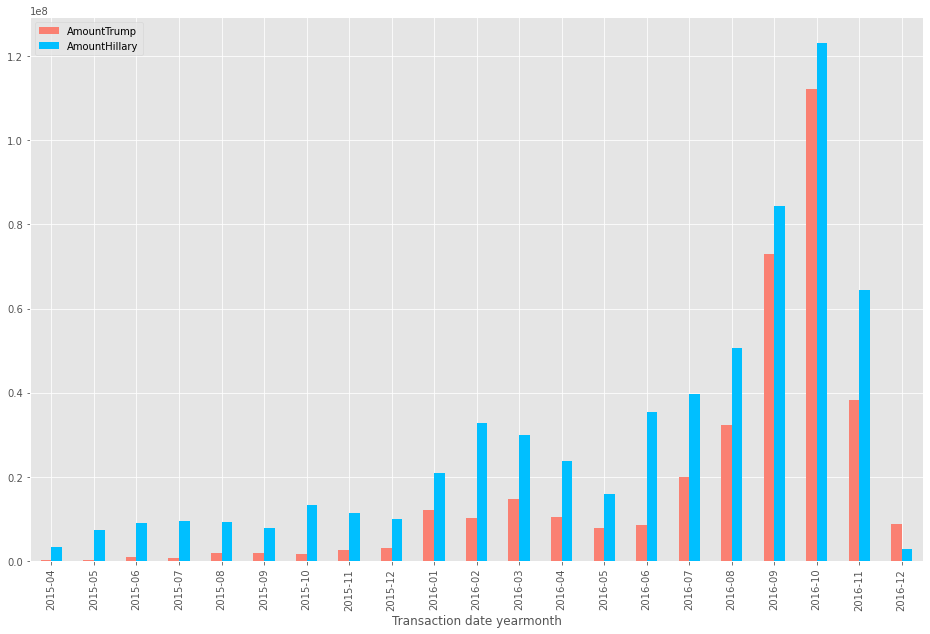

In [52]:
ax = CampaignPlot.plot(kind='bar', color=('salmon','deepskyblue'), figsize=(16, 10))

Note: We observe that the first expenditures are very low, and are raised by small amounts month by month until the last 3 months of elections where they are raised by huge amounts compared to the first.

###  Contributions made to campaigns

In order to find the contributions to the campaign committees of each candidate, we will search on 2 different dataframes.

We already have the one which is the individual contributions. From this dataframe we will keep only rows which contain the campaign committees for each candidate, and keep only the columns with amounts and dates.

## Hillary

In [53]:
fecH = fec[fec['CMTE_ID'].isin(['C00575795'])]
fecH = fecH[["TRANSACTION_DT","TRANSACTION_AMT"]]
fecH.sample(5)

,TRANSACTION_DT,TRANSACTION_AMT
8102453,2016-11-06,200.000000
8046001,2016-10-28,100.000000
7878494,2016-10-31,50.000000
9678466,2016-10-15,5.000000
13507032,2016-07-18,8.000000


## Trump

In [54]:
fecT = fec[fec['CMTE_ID'].isin(['C00580100'])]
fecT = fecT[["TRANSACTION_DT","TRANSACTION_AMT"]]
fecT.sample(5)

,TRANSACTION_DT,TRANSACTION_AMT
17593695,2016-10-07,240.000000
13092014,2016-06-22,250.000000
17609188,2016-07-21,50.000000
13083884,2016-06-25,500.000000
17637235,2016-12-01,2700.000000


The second list we are going to need is the contributions from committees to other committees. 

We will first import the headers

In [55]:
headers =  pd.read_csv(
    'https://www.fec.gov/files/bulk-downloads/data_dictionaries/oth_header_file.csv')
headers
headers = headers.columns.tolist()
data_types = { header: np.str for header in headers }
data_types['TRANSACTION_AMT'] = np.float
parse_dates = ['TRANSACTION_DT']


Now we can read the file and set the datetime type to the column which has the dates of the transactions.

In [56]:

#https://www.fec.gov/files/bulk-downloads/2016/oth16.zip
comtocom = pd.read_csv('itoth.txt', 
                  sep="|", 
                  index_col=False, 
                  names=headers,
                  dtype=data_types,
                      )
comtocom['TRANSACTION_DT'] = pd.to_datetime(comtocom['TRANSACTION_DT'], format='%m%d%Y', errors='coerce')
comtocom.sample(10)

,CMTE_ID,AMNDT_IND,RPT_TP,TRANSACTION_PGI,IMAGE_NUM,TRANSACTION_TP,ENTITY_TP,NAME,CITY,STATE,ZIP_CODE,EMPLOYER,OCCUPATION,TRANSACTION_DT,TRANSACTION_AMT,OTHER_ID,TRAN_ID,FILE_NUM,MEMO_CD,MEMO_TEXT,SUB_ID
236047,C00078451,N,M3,P2016,201603169009755067,24K,CCM,MIKE BOST FOR CONGRESS COMMITTEE,MURPHYSBORO,IL,62966,NaN,NaN,2016-02-19,1000.000000,C00546499,69960276,1055463,NaN,NaN,4031620161276462420
708454,C00301358,N,Q3,G,201610110300103391,24K,NaN,BILLY LONG FOR CONGRESS,SPRINGFIELD,MO,65804,NaN,NaN,2016-09-28,1000.000000,C00460063,SB11301633914,1127457,NaN,NaN,2120820161357092281
785218,C00003418,N,30G,P,201612089040109178,15J,IND,"MCELVEEN, JOSEPH Y. MR. III",MAULDIN,SC,296621822,RETIRED,RETIRED,2016-10-04,4.000000,NaN,SA.69102392.1.TM07,1133571,X,CONTRIBUTION MEMO OF TRUMP MAKE AMERICA GREAT ...,4011820171368010114
108170,C00551648,N,YE,G2016,201601129004472378,24G,CCM,BOB GOODLATTE FOR CONGRESS COMMITTEE,ROANOKE,VA,24002,NaN,NaN,2015-12-15,4317.000000,C00257956,SB22.4546,1039129,NaN,NaN,4011220161260545978
1411656,C00084491,N,M5,P2016,201605199015546530,24K,CCM,HOEVEN FOR SENATE,ARLINGTON,VA,22215,NaN,NaN,2016-04-19,1000.000000,C00473371,11114424,1073050,NaN,CONTRIBUTION,4052020161292990187
288844,C00575795,A,30G,G2016,201702149049648934,15J,IND,"FISCHER, CARL",RICHMOND,VA,232213947,NaN,RETIRED,2016-11-02,25.000000,NaN,C15373257,1148953,X,* HILLARY VICTORY FUND,4021720171371779873
1465638,C00338087,N,M6,G2016,201606209018463801,24K,CCM,PRICE FOR CONGRESS COMMITTEE,RALEIGH,NC,27602,NaN,NaN,2016-05-25,1000.000000,C00195628,B602459,1078637,NaN,NaN,4062020161299849487
999340,C00304758,A,Q2,P2016,201607200200272826,15J,IND,"HOLMES, FIELDING",SAINT LOUIS,MO,631241120,NOT APPLICABLE,RETIRED,2016-04-26,500.000000,NaN,SA07241628261793,1090660,X,NaN,1111520160032640284
828486,C00003418,N,30G,P,201612089040115224,15J,IND,"WILLIAMS, HARRY C. MR.",POCOMOKE CITY,MD,218512758,RETIRED,RETIRED,2016-09-27,10.000000,NaN,SA.68338279.1.TM06,1133571,X,CONTRIBUTION MEMO OF TRUMP MAKE AMERICA GREAT ...,4011820171368028253
1638185,C00580100,A,M8,P2016,201811199133736173,15J,IND,"HAHN, MARK",CENTENNIAL,CO,80121,RETIRED,RETIRED,2016-07-05,2.000000,NaN,SA18.1493965,1291697,X,NaN,4112020181618525121


We only need the 3 columns, amount, date and committee so we keep these.

In [57]:
comtocom = comtocom[['TRANSACTION_AMT','TRANSACTION_DT','CMTE_ID']]

### Hillary

We ,now, search the campaign committee for Hillary (her id is P00003392) and keep only these rows.

In [58]:
comtocomH = comtocom[comtocom['CMTE_ID'].isin(['C00575795'])]
comtocomH = comtocomH[["TRANSACTION_DT","TRANSACTION_AMT"]]
comtocomH.sample(5)

,TRANSACTION_DT,TRANSACTION_AMT
1051982,2016-06-27,3.000000
1064303,2016-06-25,10.000000
494727,2016-09-28,50.000000
769828,2016-08-15,500.000000
369685,2016-11-06,10.000000


# Trump

We ,now, search the campaign committee for trump (his id is P80001571)

In [59]:
comtocomΤ = comtocom[comtocom['CMTE_ID'].isin(['C00580100'])]
comtocomΤ = comtocomΤ[["TRANSACTION_DT","TRANSACTION_AMT"]]
comtocomΤ.sample(5)

,TRANSACTION_DT,TRANSACTION_AMT
1854103,2016-07-12,4.000000
1633504,2016-07-01,80.000000
1820742,2016-06-22,28.000000
1682382,2016-07-01,40.000000
1559477,2016-07-01,80.000000


Now we need to combine the 2 dataframes that are now 4 (2 for each candidate, one from individuals one from commites)

First we will merge for Hillary

In [60]:
HillaryIncome = pd.concat([fecH, comtocomH], ignore_index=True)
HillaryIncome.head(5)

,TRANSACTION_DT,TRANSACTION_AMT
0,2015-06-11,100.000000
1,2015-06-15,50.000000
2,2015-04-12,5.000000
3,2015-06-13,50.000000
4,2015-06-12,50.000000


We will then merge for Trump

In [61]:
TrumpIncome = pd.concat([fecT,comtocomΤ], ignore_index=True)
TrumpIncome.head(5)

,TRANSACTION_DT,TRANSACTION_AMT
0,2015-11-11,60.000000
1,2015-11-22,100.000000
2,2015-12-31,50.000000
3,2015-11-28,162.000000
4,2015-12-27,10.000000


It is time now to group the income by year and month for Hillary in order to observe the chronological evolution of the transactions

In [62]:
IH=HillaryIncome.groupby([(HillaryIncome["TRANSACTION_DT"].dt.year),(HillaryIncome["TRANSACTION_DT"].dt.month)]).sum()
IH

TRANSACTION_AMT
TRANSACTION_DT TRANSACTION_DT                 
2015           4               13272016.000000
               5               12064803.000000
               6               14264440.000000
               7                7234371.000000
               8                5937058.000000
               9                9993400.000000
               10               8436335.000000
               11               9450656.000000
               12              12548246.000000
2016           1               10975200.000000
               2               20655737.000000
               3               18037317.000000
               4               22178390.000000
               5               25114954.000000
               6               38896015.000000
               7               58113208.000000
               8               83728596.000000
               9               93406939.000000
               10             112588244.000000
               11              40427443.000000
               12                 74504.000000

Here we calculate the total income for the Hillary campaign, just to have an overview of the total.

In [63]:
HillaryIncomeTotal = HillaryIncome["TRANSACTION_AMT"].sum()
HillaryIncomeTotal

617397872.0

It is time now to group the income by year and month for Trump in order to observe the chronological evolution of the transactions

In [64]:
IT=TrumpIncome.groupby([(TrumpIncome["TRANSACTION_DT"].dt.year),(TrumpIncome["TRANSACTION_DT"].dt.month)]).sum()
IT

TRANSACTION_AMT
TRANSACTION_DT TRANSACTION_DT                 
2006           8                    400.000000
2015           4                 292650.000000
               5                 430450.000000
               6                1134722.000000
               7                 227784.000000
               8                 590794.000000
               9                 344275.000000
               10               1273707.000000
               11               2490722.000000
               12               7722930.000000
2016           1                5150431.000000
               2                7305763.000000
               3               12228870.000000
               4                7972902.000000
               5                4043663.000000
               6               20295035.000000
               7               35445874.000000
               8               37994562.000000
               9               53910467.000000
               10              69273101.000000
               11              17356570.000000
               12               4622827.000000

Here we calculate the total income for the Trump campaign, just to have an overview of the total.

In [65]:
TrumpIncomeTotal = TrumpIncome["TRANSACTION_AMT"].sum()
TrumpIncomeTotal

290108499.0

### Plot of Chronological evolution for both candidates

We can now use the dataframes, grouped by year and month, to merge them and have a dataframe with each year and month, and on the right 2 columns, each one containing the income of the month for each candidate. We then plot these 2 columns based on the first column(date), and visualise the data on a common plot.

In [66]:
TrumpIncome['Transaction date per year and month'] = TrumpIncome['TRANSACTION_DT'].dt.to_period('M')
HillaryIncome['Transaction date per year and month'] = HillaryIncome['TRANSACTION_DT'].dt.to_period('M')

TIym= TrumpIncome\
                       .groupby(['Transaction date per year and month'
])['TRANSACTION_AMT'].sum()\
   .to_frame('AmountTrump')
TIym.sort_values('Transaction date per year and month',ascending=False)


HIym= HillaryIncome\
                       .groupby(['Transaction date per year and month'
])['TRANSACTION_AMT'].sum()\
   .to_frame('AmountHillary')
HIym.sort_values('Transaction date per year and month',ascending=False)

CampaignIncomePlot = pd.merge(TIym, 
               HIym, 
               on='Transaction date per year and month',
               how='inner')

CampaignIncomePlot.head(5)

,AmountTrump,AmountHillary
Transaction date per year and month,,
2015-04,292650.000000,13272016.000000
2015-05,430450.000000,12064803.000000
2015-06,1134722.000000,14264440.000000
2015-07,227784.000000,7234371.000000
2015-08,590794.000000,5937058.000000


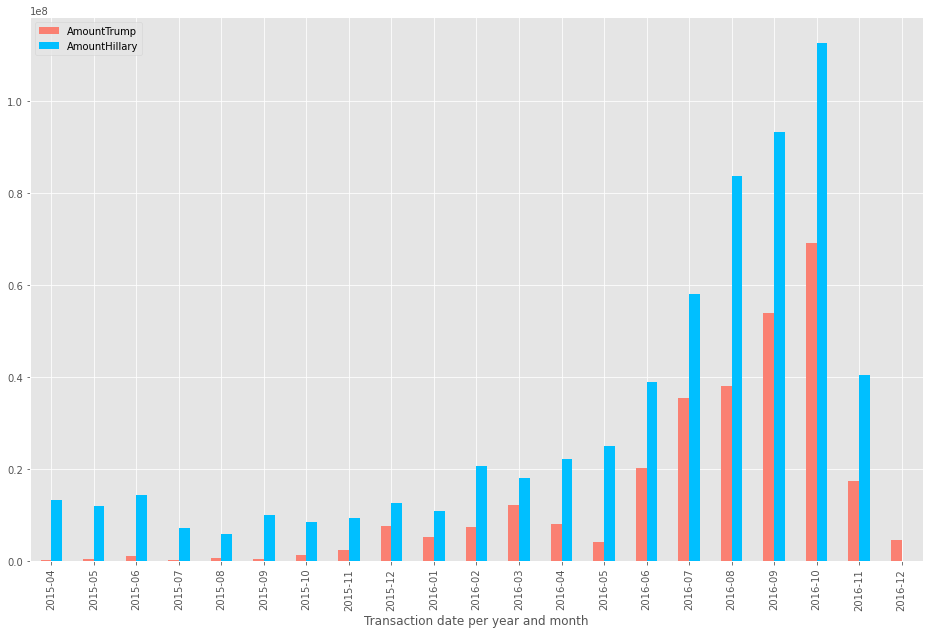

In [67]:
ax = CampaignIncomePlot.plot(kind='bar', color=('salmon','deepskyblue'), figsize=(16, 10))

Note: We can clearly see that the transactions to candidate's committees start with a small peak, where the candidates start their campaign and probably are announced and heard, and then there are smaller amounts, and start growing month by month until they reach their peak just before the elections.

For the fourth question: 

>Identify the biggest recipients of campaign expenditures.

For this question we are going to need a file we have already read, which is the operating expenditures. We will use the one dataframe that contains only transactions for Hillary and the one dataframe that contains only the transaction for Hillary. (Based on the corresponding campaign committee)

We want to identify the biggest recepients, which is the column name, that's why we will have a group by name, and sum the transaction amount. 

###  For Hillary

In [68]:
HillaryRecepients = HillaryExpenditures\
                       .groupby(['NAME'])['TRANSACTION_AMT'].sum()\
   .sort_values(ascending=False)
#.to_frame('amount').reset_index()
HillaryRecepients.head(10)

NAME
GMMB                           308463389.360000
BULLY PULPIT INTERACTIVE LLC    33306462.950000
ADP                             27902805.450000
AMERICAN EXPRESS                23922833.890000
MARKHAM PRODUCTIONS             16025851.540000
EXECUTIVE FLITEWAYS             15866289.310000
AIR PARTNERS, INC.              11156326.380000
STRIPE                          10199840.660000
AETNA                            5883908.500000
MISSION CONTROL, INC.            5837599.860000
Name: TRANSACTION_AMT, dtype: float64

###  For Trump

In [69]:
TrumpRecepients = TrumpExpenditures\
                       .groupby(['NAME'])['TRANSACTION_AMT'].sum()\
   .sort_values(ascending=False)
#.to_frame('amount').reset_index()
TrumpRecepients.head(10)

NAME
GILES-PARSCALE                    87838378.100000
AMERICAN MEDIA & ADVOCACY GROUP   74176379.300000
RICK REED MEDIA, INC.             24359873.080000
AMERICAN EXPRESS                  19393367.830000
ACE SPECIALTIES, LLC              15885323.630000
PRIVATE JET SERVICES, LLC          9953216.060000
JAMESTOWN ASSOCIATES               8836175.010000
TAG AIR, INC.                      8741464.250000
AIR CHARTER TEAM                   8321403.260000
CAMBRIDGE ANALYTICA, LLC           5912500.000000
Name: TRANSACTION_AMT, dtype: float64

#### Note: We did not remove the negative amounts, because we do not consider that a recipient accepted 50 million if the 49 million were taken back. (For example canceled events or ads or any orders that were canceled)



For the Fifth question: 

>Examine the geographical distribution, at the state level, of campaign expenditures. For each state, calculate the expenditures per voter. This will require that you find a source with the number of registered voters per state. Examine the situation for swing states

We first need to read the file of registered voters per state from this [link](https://www2.census.gov/programs-surveys/cps/tables/p20/580/table04a.xlsx).
The numbers are in thousands.

In [70]:
registered =pd.read_excel("https://www2.census.gov/programs-surveys/cps/tables/p20/580/table04a.xlsx")
registered.head(10)

,"Table with row headers in column A, and column headers in rows 4 through 5.",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,Table 4a. Reported Voting and Registration of...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,(In thousands),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,STATE,Total Population,Total Citizen Population,Registered,NaN,NaN,NaN,NaN,Voted,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,Total registered,Percent registered\n(Total),Margin of Error 1,Percent registered\n(Citizen),Margin of Error 1,Total voted,Percent voted\n(Total),Margin of Error 1,Percent voted\n(Citizen),Margin of Error 1
4,UNITED STATES,245502,224059,157596,64.193500,0.297610,70.336900,0.296800,137537,56.022600,0.308120,61.384100,0.316360
5,ALABAMA,3717,3651,2526,67.961700,2.502410,69.181600,2.498360,2095,56.371200,2.659540,57.383000,2.675700
6,ALASKA,518,502,358,69.065300,2.649860,71.303600,2.634910,308,59.406100,2.815240,61.331300,2.836720
7,ARIZONA,5196,4585,3145,60.533200,2.246090,68.609000,2.270390,2769,53.288000,2.292680,60.397200,2.392650
8,ARKANSAS,2216,2116,1456,65.685800,2.650210,68.802600,2.646890,1241,56.010600,2.770880,58.668300,2.813310
9,CALIFORNIA,29894,24890,16096,53.843200,0.955110,64.667600,1.003650,14416,48.224700,0.957340,57.919600,1.036580


From this excel we only need the states and the corresponding number of registered voters, thats why we keep these columns

In [71]:
registered = registered[['Table with row headers in column A, and column headers in rows 4 through 5.','Unnamed: 3']]

Because of the format of the file there are also some extra rows, that's why we exlude them.

In [72]:
registered = registered.loc[4:55,:]
registered.head(5)

,"Table with row headers in column A, and column headers in rows 4 through 5.",Unnamed: 3
4,UNITED STATES,157596
5,ALABAMA,2526
6,ALASKA,358
7,ARIZONA,3145
8,ARKANSAS,1456


We will also rename the column names so that they will be accurate on what they represent.

In [73]:
registered.columns = ['State', 'Registered Voters']
registered.head(5)

,State,Registered Voters
4,UNITED STATES,157596
5,ALABAMA,2526
6,ALASKA,358
7,ARIZONA,3145
8,ARKANSAS,1456


Note: The first row is the total registered voters

We will now print the expenditures table that we created earlier to see how it is stractured.

In [74]:
TrumpExpenditures.head(5)

,CMTE_ID,CMTE_NM,CMTE_TP,CAND_ID,NAME,TRANSACTION_DT,TRANSACTION_AMT,CATEGORY,STATE,Transaction date yearmonth
2659,C00580100,"DONALD J. TRUMP FOR PRESIDENT, INC.",P,P80001571,"WHITEHOUSE, JOSHUA",2015-04-09,1873.530000,NaN,NH,2015-04
2784,C00580100,"DONALD J. TRUMP FOR PRESIDENT, INC.",P,P80001571,"DRAKE VENTURES, LLC",2015-04-10,10000.000000,NaN,FL,2015-04
2651,C00580100,"DONALD J. TRUMP FOR PRESIDENT, INC.",P,P80001571,"HUPKE, CHRIS",2015-04-10,4000.000000,NaN,IA,2015-04
2575,C00580100,"DONALD J. TRUMP FOR PRESIDENT, INC.",P,P80001571,"JENSEN & ASSOCIATES, APC",2015-04-10,487.500000,NaN,CA,2015-04
2750,C00580100,"DONALD J. TRUMP FOR PRESIDENT, INC.",P,P80001571,"GREEN MONSTER CONSULTING, LLC",2015-04-10,29267.700000,NaN,NH,2015-04


We see that there is a column called State, in which we are interested, but the States are written by 2 letters so we need to convert the registered dataframe to have only 2 letter names.


In order to do that convertion we will use this [list](https://answers.microsoft.com/en-us/msoffice/forum/msoffice_excel-mso_other-mso_archive/converting-state-name-to-2-letters/7714ab99-b0d4-4a1d-86e5-ec58e5771cbc) which contains all States and their 2 letter version. We first read it/

In [75]:
# Code for getting table from a site
url = 'https://answers.microsoft.com/en-us/msoffice/forum/msoffice_excel-mso_other-mso_archive/converting-state-name-to-2-letters/7714ab99-b0d4-4a1d-86e5-ec58e5771cbc'
html = requests.get(url).content
df_list = pd.read_html(html)
states2 = df_list[-1]
states2.head(5)

,0,1
0,State,USPS Abbrev
1,Alabama,AL
2,Alaska,AK
3,Arizona,AZ
4,Arkansas,AR


We then merge the table with the registered voters, with the table that contains both the State's name and its 2-letter name. We need to use .upper so that letters are capital.

In [76]:
states2.columns = ['State', 'STATE']
states2['State'] = states2['State'].str.upper() 
registered = pd.merge(registered, 
               states2, 
               on='State',
               how='inner')
registered.head(5)

,State,Registered Voters,STATE
0,ALABAMA,2526,AL
1,ALASKA,358,AK
2,ARIZONA,3145,AZ
3,ARKANSAS,1456,AR
4,CALIFORNIA,16096,CA


Let's go back to our expenditures dataframe, we will group by State summing the expenditure amounts for Trump.

In [77]:
TrumpExpendituresperState = TrumpExpenditures.groupby(['STATE'])['TRANSACTION_AMT'].sum()\
   .sort_values(ascending=False).to_frame("amount").reset_index()
TrumpExpendituresperState.head(10)

,STATE,amount
0,VA,110657185.240000
1,TX,97271455.009999
2,NY,27471091.740000
3,NJ,19253807.780000
4,LA,17121587.250000
5,FL,14985463.300000
6,NH,11576884.330000
7,MO,9522826.140000
8,CA,9120311.400000
9,DC,7095697.020000


We can now merge this table with the number of the registered voters per State, if we merge the 2 tables based on State (Note that if we did'nt have the the 2-letter States we wouldn't be able to do the merge)

In [78]:
TrumpExpendituresperStateAndVoters = pd.merge(TrumpExpendituresperState, 
               registered, 
               on='STATE',
               how='inner')
TrumpExpendituresperStateAndVoters.head(10)

,STATE,amount,State,Registered Voters
0,VA,110657185.240000,VIRGINIA,4399
1,TX,97271455.009999,TEXAS,11724
2,NY,27471091.740000,NEW YORK,9142
3,NJ,19253807.780000,NEW JERSEY,4165
4,LA,17121587.250000,LOUISIANA,2446
5,FL,14985463.300000,FLORIDA,9604
6,NH,11576884.330000,NEW HAMPSHIRE,763
7,MO,9522826.140000,MISSOURI,3333
8,CA,9120311.400000,CALIFORNIA,16096
9,OH,4373003.420000,OHIO,6128


Now we can simply divide expenditures per State with the voters per State (multiplied by 1000 as the number is in thousands). This way we will get Expenditures per Voter for Trump

In [79]:
TrumpExpendituresperStateAndVoters["expenditures per voter"] = TrumpExpendituresperStateAndVoters["amount"]/(TrumpExpendituresperStateAndVoters["Registered Voters"]*1000)
TrumpExpendituresperStateAndVoters.head(5)

,STATE,amount,State,Registered Voters,expenditures per voter
0,VA,110657185.240000,VIRGINIA,4399,25.155077
1,TX,97271455.009999,TEXAS,11724,8.296781
2,NY,27471091.740000,NEW YORK,9142,3.004932
3,NJ,19253807.780000,NEW JERSEY,4165,4.622763
4,LA,17121587.250000,LOUISIANA,2446,6.999831


Let's see the top 10 and the bottom 10 of this list, but in order to do that we need to sort by the expenditures per voter.


In [80]:
TrumpExpendituresperStateAndVoters = TrumpExpendituresperStateAndVoters.sort_values(by=['expenditures per voter'],ascending=False)
TrumpExpendituresperStateAndVoters.head(10)

,STATE,amount,State,Registered Voters,expenditures per voter
0,VA,110657185.240000,VIRGINIA,4399,25.155077
6,NH,11576884.330000,NEW HAMPSHIRE,763,15.172850
1,TX,97271455.009999,TEXAS,11724,8.296781
4,LA,17121587.250000,LOUISIANA,2446,6.999831
3,NJ,19253807.780000,NEW JERSEY,4165,4.622763
2,NY,27471091.740000,NEW YORK,9142,3.004932
7,MO,9522826.140000,MISSOURI,3333,2.857134
14,IA,2614103.020000,IOWA,1657,1.577612
5,FL,14985463.300000,FLORIDA,9604,1.560336
10,AZ,3390083.230000,ARIZONA,3145,1.077928


In [81]:
TrumpExpendituresperStateAndVoters.tail(10)

,STATE,amount,State,Registered Voters,expenditures per voter
37,AR,170702.770000,ARKANSAS,1456,0.117241
34,OR,242283.580000,OREGON,2147,0.112847
44,MT,58173.080000,MONTANA,581,0.100126
42,WV,91403.330000,WEST VIRGINIA,913,0.100113
45,ID,50818.390000,IDAHO,790,0.064327
46,AK,20244.870000,ALASKA,358,0.056550
47,SD,19498.550000,SOUTH DAKOTA,437,0.044619
48,ND,15350.000000,NORTH DAKOTA,424,0.036203
41,MN,91759.460000,MINNESOTA,3055,0.030036
49,HI,15242.750000,HAWAII,530,0.028760


We will now do the same for Hillary.
We first group Hillary's expenditures by State summing the amounts.

In [82]:
HillaryExpendituresperState = HillaryExpenditures.groupby(['STATE'])['TRANSACTION_AMT'].sum()\
   .sort_values(ascending=False).to_frame("amount").reset_index()
HillaryExpendituresperState.head(10)

,STATE,amount
0,DC,352852930.080000
1,NY,80064810.029999
2,NJ,54177832.750000
3,CA,16559604.860000
4,AR,16349978.170000
5,FL,12469089.870000
6,CT,11195943.420000
7,WA,8417873.400000
8,VA,7727133.340000
9,IL,6619419.230000


We will then merge it with the registered voters just like Trump

In [83]:
HillaryExpendituresperStateAndVoters = pd.merge(HillaryExpendituresperState, 
               registered, 
               on='STATE',
               how='inner')
HillaryExpendituresperStateAndVoters.head(10)

,STATE,amount,State,Registered Voters
0,NY,80064810.029999,NEW YORK,9142
1,NJ,54177832.750000,NEW JERSEY,4165
2,CA,16559604.860000,CALIFORNIA,16096
3,AR,16349978.170000,ARKANSAS,1456
4,FL,12469089.870000,FLORIDA,9604
5,CT,11195943.420000,CONNECTICUT,1763
6,WA,8417873.400000,WASHINGTON,3906
7,VA,7727133.340000,VIRGINIA,4399
8,IL,6619419.230000,ILLINOIS,6665
9,TX,5261605.690000,TEXAS,11724


Finally, we will do the same calculations as above.

In [84]:
HillaryExpendituresperStateAndVoters["expenditures per voter"] = HillaryExpendituresperStateAndVoters["amount"]/(HillaryExpendituresperStateAndVoters["Registered Voters"]*1000)
HillaryExpendituresperStateAndVoters.head(5)

,STATE,amount,State,Registered Voters,expenditures per voter
0,NY,80064810.029999,NEW YORK,9142,8.757910
1,NJ,54177832.750000,NEW JERSEY,4165,13.007883
2,CA,16559604.860000,CALIFORNIA,16096,1.028802
3,AR,16349978.170000,ARKANSAS,1456,11.229381
4,FL,12469089.870000,FLORIDA,9604,1.298323


And then sort it by expenditures per voter.

In [85]:
HillaryExpendituresperStateAndVoters = HillaryExpendituresperStateAndVoters.sort_values(by=['expenditures per voter'],ascending=False)
HillaryExpendituresperStateAndVoters.head(10)

,STATE,amount,State,Registered Voters,expenditures per voter
1,NJ,54177832.750000,NEW JERSEY,4165,13.007883
3,AR,16349978.170000,ARKANSAS,1456,11.229381
0,NY,80064810.029999,NEW YORK,9142,8.757910
12,RI,3498702.400000,RHODE ISLAND,538,6.503164
5,CT,11195943.420000,CONNECTICUT,1763,6.350507
6,WA,8417873.400000,WASHINGTON,3906,2.155114
13,IA,3177564.490000,IOWA,1657,1.917661
7,VA,7727133.340000,VIRGINIA,4399,1.756566
10,CO,5053106.740000,COLORADO,2893,1.746667
16,NV,1854430.240000,NEVADA,1371,1.352611


In [86]:
HillaryExpendituresperStateAndVoters.tail(10)

,STATE,amount,State,Registered Voters,expenditures per voter
40,NM,55245.800000,NEW MEXICO,916,0.060312
31,IN,175160.780000,INDIANA,3298,0.053111
33,KY,117664.390000,KENTUCKY,2253,0.052226
35,MS,85625.450000,MISSISSIPPI,1725,0.049638
37,KS,68338.220000,KANSAS,1438,0.047523
45,ID,27243.040000,IDAHO,790,0.034485
48,MT,16123.900000,MONTANA,581,0.027752
38,LA,67739.810000,LOUISIANA,2446,0.027694
47,WV,21230.490000,WEST VIRGINIA,913,0.023254
49,ND,5316.670000,NORTH DAKOTA,424,0.012539


Finally, we can do a comparison of expenditures per voter by State, by having them side to side

In [87]:
#Keep the columns needed
HillaryExpendituresperStateAndVotersSTATE = HillaryExpendituresperStateAndVoters [["STATE","expenditures per voter"]]
TrumpExpendituresperStateAndVotersSTATE = TrumpExpendituresperStateAndVoters [["STATE","expenditures per voter"]]

#Rename columns
HillaryExpendituresperStateAndVotersSTATE.columns = ["STATE",'Hillarys exp. per voter']
TrumpExpendituresperStateAndVotersSTATE.columns = ["STATE",'Trumps exp. per voter']

#Merge the 2 frames
Expenditures = pd.merge(HillaryExpendituresperStateAndVotersSTATE, 
               TrumpExpendituresperStateAndVotersSTATE, 
               on='STATE',
               how='inner')


#Set index to State
Expenditures = Expenditures.set_index('STATE')
#display
Expenditures

,Hillarys exp. per voter,Trumps exp. per voter
STATE,,
NJ,13.007883,4.622763
AR,11.229381,0.117241
NY,8.757910,3.004932
RI,6.503164,0.190882
CT,6.350507,0.641409
WA,2.155114,0.278296
IA,1.917661,1.577612
VA,1.756566,25.155077
CO,1.746667,0.975271


### Swing states

We will now investigate the amounts spent on Swing States. We will import the list with the Swing States of 2016 from [this list](https://en.wikipedia.org/wiki/Swing_state#Determining_swing_states).

In [88]:
url = 'https://en.wikipedia.org/wiki/Swing_state#Determining_swing_states'
html = requests.get(url).content
df_list = pd.read_html(html)
#take the second table from bottom
df = df_list[-2]
Swing_States = df[["2016 election"]]
Swing_States

,2016 election
0,Maine
1,Nevada
2,Minnesota
3,New Hampshire
4,Michigan
5,Pennsylvania[note 1]
6,Wisconsin[note 1]
7,Florida
8,Arizona
9,North Carolina


We need to change the states that have notes to just the state name, make the letters capitals and give the column the name State to use it for merging.

In [94]:
Swing_States.at[5, '2016 election']="Pennsylvania"
Swing_States.at[6, '2016 election']="Wisconsin"
Swing_States.columns = ['State']
Swing_States.loc[:,'State'] = Swing_States.loc[:,'State'].str.upper() 
Swing_States

C:\Users\Sterg\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Sterg\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


ValueError: Length mismatch: Expected axis has 2 elements, new values have 1 elements

Now we need will merge the swing list with each candidate's list of expenditure per voters

We start with Hillary's.

In [90]:
HillarySwing = pd.merge(Swing_States, 
               HillaryExpendituresperStateAndVoters, 
               on='State',
               how='inner')
HillarySwing

,State,STATE,amount,Registered Voters,expenditures per voter
0,MAINE,ME,91178.280000,830,0.109853
1,NEVADA,NV,1854430.240000,1371,1.352611
2,MINNESOTA,MN,681581.000000,3055,0.223103
3,NEW HAMPSHIRE,NH,779205.890000,763,1.021240
4,MICHIGAN,MI,558990.180000,5434,0.102869
5,PENNSYLVANIA,PA,3568929.320000,6909,0.516562
6,WISCONSIN,WI,215986.800000,3323,0.064998
7,FLORIDA,FL,12469089.870000,9604,1.298323
8,ARIZONA,AZ,223656.150000,3145,0.071115
9,NORTH CAROLINA,NC,543876.160000,5194,0.104712


And now we proceed with Trump 

In [91]:
TrumpSwing = pd.merge(Swing_States, 
               TrumpExpendituresperStateAndVoters, 
               on='State',
               how='inner')
TrumpSwing

,State,STATE,amount,Registered Voters,expenditures per voter
0,MAINE,ME,116729.710000,830,0.140638
1,NEVADA,NV,1132280.130000,1371,0.825879
2,MINNESOTA,MN,91759.460000,3055,0.030036
3,NEW HAMPSHIRE,NH,11576884.330000,763,15.172850
4,MICHIGAN,MI,869749.730000,5434,0.160057
5,PENNSYLVANIA,PA,1586013.350000,6909,0.229558
6,WISCONSIN,WI,964820.580000,3323,0.290346
7,FLORIDA,FL,14985463.300000,9604,1.560336
8,ARIZONA,AZ,3390083.230000,3145,1.077928
9,NORTH CAROLINA,NC,1435016.940000,5194,0.276284


In [92]:
HillarySwing = HillarySwing [["State","expenditures per voter"]]
TrumpSwing = TrumpSwing [["State","expenditures per voter"]]
HillarySwing.columns = ["State",'Hillarys exp. per voter']
TrumpSwing.columns = ["State",'Trumps exp. per voter']
Swings = pd.merge(TrumpSwing, 
               HillarySwing, 
               on='State',
               how='inner')
#Visualise the first 5 rows
Swings = Swings.set_index('State')

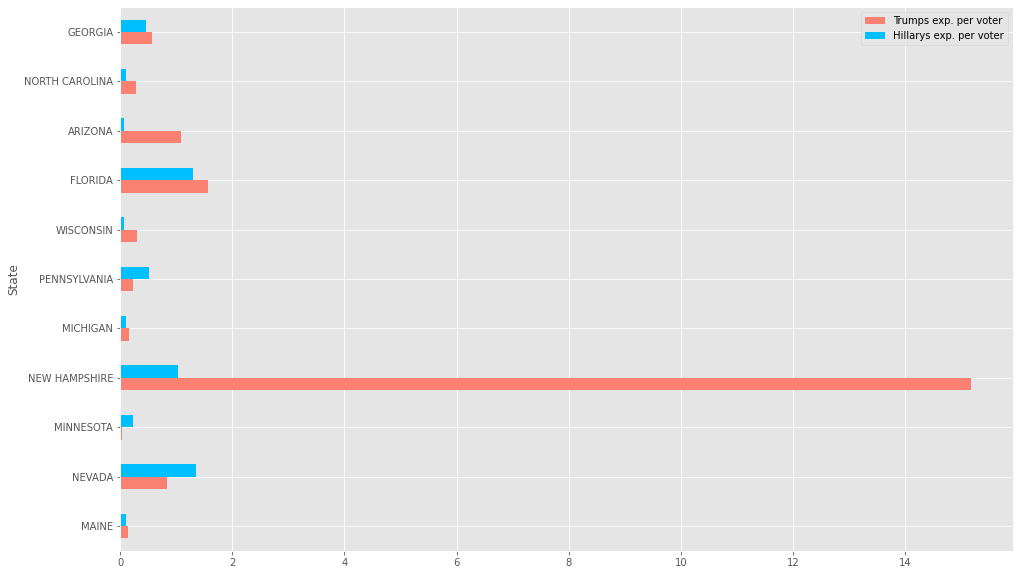

In [93]:
ax = Swings.plot(kind='barh', color=('salmon','deepskyblue'), figsize=(16, 10))

Note about Swing States:
   
Swing States are the key States for each year, in the way that they are:
>a US state where the two major political parties have similar levels of support among voters, viewed as important in determining the overall result of a presidential election.

The plot above shows thut Trump has spent more money than Hillary, per voter, and indeed the final result is that all Swing States except for 4(New Hampshire,Minnesota,Nevada,Maine) were won by Trump